In [32]:
import json
import pystac
import stackstac
import os
import xarray as xr
import geopandas as gpd
from shapely import Polygon
import matplotlib.pyplot as plt
import pandas as pd
import rioxarray as rio
from rasterio.crs import CRS
import rasterio 
import matplotlib.patches as mpatches
import numpy as np

## Utility fns

In [2]:
def check_orig_files(item):
    
    file_ls = ['orig_file_dis_az', 'orig_file_dis_mag','orig_file_dis_N_ang','orig_file_dis_r']
    
    dt_ls, ref_date_ls, sec_date_ls = [],[],[]
    for file in file_ls:
        
        var_name_dt = f'{file}_datetime'
        var_name_ref = f'{file}_ref_date'
        var_name_sec = f'{file}_sec_date'
        
        var_name_dt = item.extra_fields[file][22:30]
        var_name_ref = item.extra_fields[file].split('+S1_')[1][:15]
        var_name_sec = item.extra_fields[file].split('+S1_')[1].split('_')[9]
        
        dt_ls.append(var_name_dt)
        ref_date_ls.append(var_name_ref)
        sec_date_ls.append(var_name_sec)
       
    if len(set(dt_ls)) != 1:
           print('issue w dt')
    elif len(set(ref_date_ls)) != 1:
             print('issue with ref date')
             
    elif len(set(sec_date_ls)) != 1:
             print('issue w sec date')

In [3]:
def get_footprint(ds):
    ''' returns a geopandas geodataframe with the outline of an xarray object.
    xr object must have crs formatted (ie ds.crs returns epsg code)
    '''
    
    left = ds.x.data.min()
    right = ds.x.data.max()
    bottom = ds.y.data.min()
    top = ds.y.data.max()

    bbox = [left, bottom, right, top]
    
    footprint = Polygon([
                [bbox[0], bbox[1]],
                [bbox[0], bbox[3]],
                [bbox[2], bbox[3]],
                [bbox[2], bbox[1]]
                ])
    
    gdf = gpd.GeoDataFrame(index=[0], crs = ds.crs, geometry = [footprint])
    
    return gdf
    
    

## Read in STAC catalog, explore metadata

In [4]:
catalog = pystac.Catalog.from_file('/home/emmamarshall/Desktop/phd_work/retreat/retreat/BB310TEST_STAC_CATALOG/catalog.json')

In [5]:
items = list(catalog.get_all_items())

In [6]:
for item in items:
    
    check_orig_files(item)

In [7]:
feature_coll = [item.to_dict() for item in items]

In [8]:
gdf = gpd.GeoDataFrame.from_features(feature_coll)

In [9]:
gdf = gdf.set_crs('EPSG:4326')
gdf_prj = gdf.to_crs('EPSG:32645')

<AxesSubplot: >

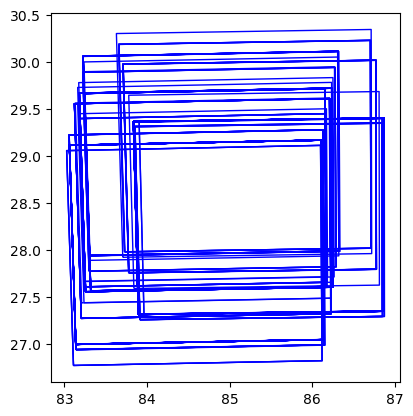

In [10]:
gdf.plot(facecolor='None', edgecolor='blue')

In [19]:
catalog

<Catalog id=NEW RETREAT data, Langtang>

## Explore RETREAT data

In [11]:
cube = stackstac.stack(
    items = [item.to_dict() for item in items])

In [12]:
cube.isel(time=1)

<xarray.DataArray 'stackstac-827c0b1fe8061792fbab2f7102c0f3d1' (band: 5,
                                                                y: 1951, x: 1875)>
dask.array<getitem, shape=(5, 1951, 1875), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/17)
    time       datetime64[ns] 2014-10-31
    id         <U19 '10_019_001_20141031'
  * band       (band) <U9 'dis_ang' 'dis_az' 'dis_mag' 'dis_N_ang' 'dis_r'
  * x          (x) float64 1.128e+05 1.13e+05 1.132e+05 ... 4.874e+05 4.876e+05
  * y          (y) float64 3.357e+06 3.357e+06 3.357e+06 ... 2.967e+06 2.967e+06
    acq_date   <U15 '20141019T001854'
    ...         ...
    frame      <U3 '019'
    orbit      <U3 '001'
    sec_date   <U15 'S1_20141112T001'
    title      (band) <U9 'dis_ang' 'dis_az' 'dis_mag' 'dis_N_ang' 'dis_r'
    proj:epsg  int64 32645
    epsg       int64 32645
Attributes:
    spec:        RasterSpec(epsg=32645, bounds=(112800.0, 2966800.0, 487800.0...
    crs:         epsg:32645
    transform:   | 200.00, 0.00, 112800.00|\n| 0.00,-200.00, 3357000.00|\n| 0...
    resolution:  200.0

In [13]:
cube.isel(time=0).sel(band='dis_mag').mean().compute().data

<xarray.DataArray 'stackstac-827c0b1fe8061792fbab2f7102c0f3d1' ()>
array(0.02581397)
Coordinates: (12/15)
    time       datetime64[ns] 2014-10-23
    id         <U19 '10_085_002_20141023'
    band       <U9 'dis_mag'
    acq_date   <U15 '20141011T122155'
    tile       <U10 '10_085_002'
    sensor     <U2 'S1'
    ...         ...
    frame      <U3 '085'
    orbit      <U3 '002'
    sec_date   <U15 'S1_20141104T122'
    title      <U9 'dis_mag'
    proj:epsg  int64 32645
    epsg       int64 32645

### Verify against ind file

In [14]:
dismag_10232014 = xr.open_dataset('/home/emmamarshall/Desktop/phd_work/retreat/data/10_085_002/10_085_002_20141023-dis_mag+S1_20141011T122155_8496_1_10_1_10_1_10_S1_20141104T122155_D1BD_1_10_1_10_1_10+250-50_50-10_0.00-0.08_2_geo_filtered_corrected.tif').squeeze()

In [15]:
dismag_10232014.band_data.mean()

<xarray.DataArray 'band_data' ()>
array(0.02581397, dtype=float32)
Coordinates:
    band         int64 1
    spatial_ref  int64 ...

## Other data

### RGI

In [16]:
rgi_path = '/home/emmamarshall/Desktop/data/rgi/south_asia_east_15/'

In [17]:
rgi15 = gpd.read_file(os.path.join(rgi_path, '15_rgi60_SouthAsiaEast.shp'))

In [18]:
rgi15_prj = rgi15.to_crs('EPSG:32645')

In [19]:
rgi_ids = pd.read_csv('/home/emmamarshall/Desktop/phd_work/retreat/manuscript_edits/manuscript_rgi_ids.csv', )

lake_ids = ['RGI60-15.10255', 'RGI60-15.10285', 'RGI60-15.10279','RGI60-15.10286',
            'RGI60-15.09361','RGI60-15.09483','RGI60-15.10290','RGI60-15.10299']

In [20]:
rgi_subset = rgi15_prj.loc[rgi15_prj['RGIId'].isin(rgi_ids['RGI_IDs'])]

In [21]:
rgi_lakes = rgi_subset.loc[rgi_subset['RGIId'].isin(lake_ids)]

In [22]:
rgi_lands = rgi_subset.loc[~rgi_subset['RGIId'].isin(lake_ids)]


In [23]:
land_ids = rgi_lands['RGIId'].to_list()


## NASADEM

In [24]:
nasadem = xr.open_dataset('/home/emmamarshall/Desktop/data/nasadem/NASADEM_NC_n28e085.nc').squeeze()

In [25]:
nasadem = nasadem.rio.write_crs('EPSG:4326')

In [26]:
nasadem_prj = nasadem.rio.reproject('EPSG:32645')

In [27]:
nasadem_prj_footprint = get_footprint(nasadem_prj)

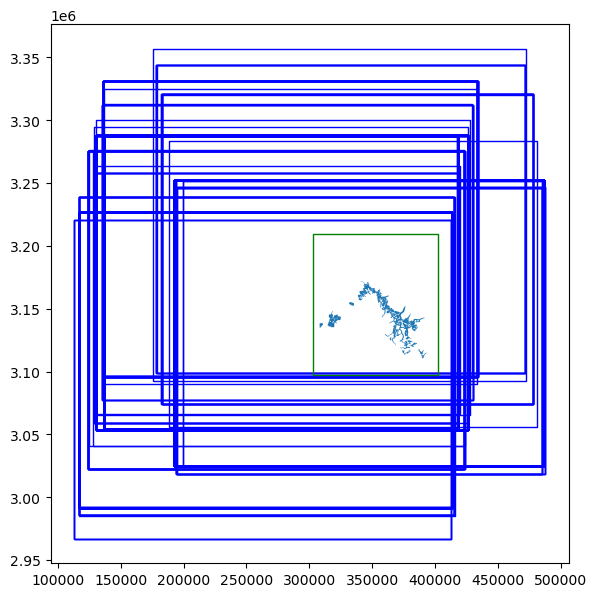

In [28]:
fig, ax = plt.subplots(figsize=(7,7))

#retreat_footprint.plot(ax=ax, facecolor='None', edgecolor='blue')
rgi = rgi_subset.plot(ax=ax, label = 'glacier outlines')
retreat_footprint = gdf_prj.plot(facecolor='None', edgecolor='blue', ax=ax, label = 'retreat data footprints')
dem_footprint = nasadem_prj_footprint.plot(facecolor='None', edgecolor='green',ax=ax, label = 'nasadem footprint')


#ax.legend(('RGI','RETREAT','NASADEM'), loc='upper right', shadow=False)
plt.show()

## Ind glacier workflow

### Fns

In [47]:
def clip_glacier_add_dem(rgi_id, rgi_full, retreat_xr, dem_xr): #all in local utm
    
    rgi_single = rgi_full.loc[rgi_full['RGIId'] == rgi_id]
    
    retreat_clip = retreat_xr.rio.clip(rgi_single.geometry, rgi_single.crs)
    
    retreat_clip_ds = retreat_clip.to_dataset(dim='band')
    
    dem_clip = dem_xr.rio.clip(rgi_single.geometry, rgi_single.crs)
    
    dem_downsamp = dem_clip.interp_like(retreat_clip_ds, method = 'nearest')
    
    zmin = np.nanmin(dem_downsamp.NASADEM_HGT.data)
    zq1 = np.nanpercentile(dem_downsamp.NASADEM_HGT.data, 25)
    zmed = np.nanmedian(dem_downsamp.NASADEM_HGT.data)
    zq3 = np.nanpercentile(dem_downsamp.NASADEM_HGT.data, 75)
    zmax = np.nanmax(dem_downsamp.NASADEM_HGT.data)
    
    z0 = dem_downsamp.NASADEM_HGT.where(np.logical_and(dem_downsamp.NASADEM_HGT >= zmin, dem_downsamp.NASADEM_HGT <= zq1), drop=True)
    z1 = dem_downsamp.NASADEM_HGT.where(np.logical_and(dem_downsamp.NASADEM_HGT >= zq1, dem_downsamp.NASADEM_HGT <= zmed), drop=True)
    z2 = dem_downsamp.NASADEM_HGT.where(np.logical_and(dem_downsamp.NASADEM_HGT >= zmed, dem_downsamp.NASADEM_HGT <= zq3), drop=True)
    z3 = dem_downsamp.NASADEM_HGT.where(np.logical_and(dem_downsamp.NASADEM_HGT >= zq3, dem_downsamp.NASADEM_HGT <= zmax), drop=True)
    
    retreat_clip_ds['z0'] = z0
    retreat_clip_ds['z1'] = z1
    retreat_clip_ds['z2'] = z2
    retreat_clip_ds['z3'] = z3
    
    z0_cond_min = retreat_clip_ds.z0.min().data >= zmin
    z0_cond_max = retreat_clip_ds.z0.max().data < zq1+1
    z1_cond_min = retreat_clip_ds.z1.min().data >= zq1
    z1_cond_max = retreat_clip_ds.z1.max().data <zmed + 1
    z2_cond_min = retreat_clip_ds.z2.min().data >= zmed
    z2_cond_max = retreat_clip_ds.z2.max().data < zq3 + 1
    z3_cond_min = retreat_clip_ds.z3.min().data >= zq3
    z3_cond_max = retreat_clip_ds.z3.max().data < zmax+1
    
    cond_ls = [z0_cond_min, z0_cond_max, z1_cond_min, z1_cond_max,
               z2_cond_min, z2_cond_max, z3_cond_min, z3_cond_max]
    
    test = all(i for i in cond_ls)
    
    if test != True:
        
        print('there is an elevation masking issue here')
        
    else:
    
        pass
    
        return retreat_clip_ds

In [53]:
def calc_seasonal_mean_by_z(input_ds, z, var, rgi_id):
        
    gb = input_ds.groupby(input_ds.time.dt.season).mean()
    
    if z == 'full':
        
        winter = gb.sel(season='DJF')[f'{var}'].mean(dim=['x','y']).compute().data*365
        spring = gb.sel(season='MAM')[f'{var}'].mean(dim=['x','y']).compute().data*365
        summer = gb.sel(season='JJA')[f'{var}'].mean(dim=['x','y']).compute().data*365
        fall = gb.sel(season='SON')[f'{var}'].mean(dim=['x','y']).compute().data*365
        
    else:
        z_gb = gb.where(gb[f'{z}'].notnull(), drop=True)

        winter = z_gb.sel(season='DJF')[f'{var}'].mean(dim=['x','y']).compute().data*365
        spring = z_gb.sel(season='MAM')[f'{var}'].mean(dim=['x','y']).compute().data*365
        summer = z_gb.sel(season='JJA')[f'{var}'].mean(dim=['x','y']).compute().data*365
        fall = z_gb.sel(season='SON')[f'{var}'].mean(dim=['x','y']).compute().data*365
    
    d = {'RGIId':rgi_id, 'z':z, 'winter': winter,
         'spring':spring, 'summer':summer, 'fall':fall}
    df = pd.DataFrame(d, index=[0])
    
    return df
    

In [49]:
ds_03976 = clip_glacier_add_dem('RGI60-15.03976', rgi_subset, cube, nasadem_prj)


In [50]:
groupby_03976 = ds_03976.groupby(ds_03976.time.dt.season).mean()

checking by hand to make sure its all good -- it is, function df below should be correct

In [52]:
winter_z0_dismag = groupby_03976.where(groupby_03976.z0.notnull(), drop=True).sel(season='DJF').dis_mag.mean(dim=['x','y']).compute().data*365
spring_z0_dismag = groupby_03976.where(groupby_03976.z0.notnull(), drop=True).sel(season='MAM').dis_mag.mean(dim=['x','y']).compute().data*365
summer_z0_dismag = groupby_03976.where(groupby_03976.z0.notnull(), drop=True).sel(season='JJA').dis_mag.mean(dim=['x','y']).compute().data*365
fall_z0_dismag = groupby_03976.where(groupby_03976.z0.notnull(), drop=True).sel(season='SON').dis_mag.mean(dim=['x','y']).compute().data*365

print(winter_z0_dismag)
print(spring_z0_dismag)
print(summer_z0_dismag)
print(fall_z0_dismag)

43.500089049598614
56.47553117056695
39.54093994895913
37.496375544561175


In [37]:
dismag_03976 = pd.concat([calc_seasonal_mean_by_z(ds_03976, z,'dis_mag','RGI60-15.03976') for z in ['z0','z1','z2','z3','full']])


In [54]:
def wrapper_single_glacier(rgi_id, rgi_full, retreat_xr, dem_xr, var):
    '''wraps the above two functions, returns a dataframe with seasonal velocities for each elevation quartile
       input args are: rgi_id (str), full or subset rgi gpdf
       retreat xr object (read from stackstac) in local utm,
       NASADEM xr object projected to local utm 
       variable for which you want seasonal means to be calculated
       
   '''
    ds = clip_glacier_add_dem(rgi_id, rgi_full, retreat_xr, dem_xr)
    
    df = pd.concat([calc_seasonal_mean_by_z(ds, z, var, rgi_id) for z in ['z0','z1','z2','z3','full']])

    return df

In [55]:
df_03976 = wrapper_single_glacier('RGI60-15.03976', rgi_subset, cube, nasadem_prj, 'dis_mag')

In [ ]:
df_lakes = pd.concat([wrapper_single_glacier(rgi_id, rgi_subset, cube, nasadem_prj, 'dis_mag') for rgi_id in lake_ids])

In [411]:
winter_z0_dismag = groupby_03976.where(groupby_03976.z1.notnull(), drop=True).sel(season='DJF').dis_mag.mean(dim=['x','y']).compute().data*365
spring_z0_dismag = groupby_03976.where(groupby_03976.z1.notnull(), drop=True).sel(season='MAM').dis_mag.mean(dim=['x','y']).compute().data*365
summer_z0_dismag = groupby_03976.where(groupby_03976.z1.notnull(), drop=True).sel(season='JJA').dis_mag.mean(dim=['x','y']).compute().data*365
fall_z0_dismag = groupby_03976.where(groupby_03976.z1.notnull(), drop=True).sel(season='SON').dis_mag.mean(dim=['x','y']).compute().data*365

print(winter_z0_dismag)
print(spring_z0_dismag)
print(summer_z0_dismag)
print(fall_z0_dismag)

49.01688174578074
58.84126650363933
52.13552099430868
48.82556403973669


In [361]:
print(retreat_03976_ds.where(retreat_03976_ds.z0.notnull(), drop=True).dis_mag.mean(dim=['x','y','time']).compute().data*365)
print(retreat_03976_ds.where(retreat_03976_ds.z1.notnull(), drop=True).dis_mag.mean(dim=['x','y','time']).compute().data*365)
print(retreat_03976_ds.where(retreat_03976_ds.z2.notnull(), drop=True).dis_mag.mean(dim=['x','y','time']).compute().data*365)
print(retreat_03976_ds.where(retreat_03976_ds.z3.notnull(), drop=True).dis_mag.mean(dim=['x','y','time']).compute().data*365)

45.30674327578146
52.206323957787
36.01065521264687
26.98912238155708


In [338]:
z0_ds = xr.where(retreat_03976_ds.z0.notnull(), retreat_03976_ds, np.nan)
z1_ds = xr.where(retreat_03976_ds.z1.notnull(), retreat_03976_ds, np.nan)
z2_ds = xr.where(retreat_03976_ds.z2.notnull(), retreat_03976_ds, np.nan)
z3_ds = xr.where(retreat_03976_ds.z3.notnull(), retreat_03976_ds, np.nan)



In [344]:
z0_new = z0_ds.where(z0_ds.z0.notnull(), drop=True)
z1_new = z1_ds.where(z1_ds.z1.notnull(), drop=True)
z2_new = z2_ds.where(z2_ds.z2.notnull(), drop=True)
z3_new = z3_ds.where(z3_ds.z3.notnull(), drop=True)

In [348]:
z0_new.x.max()

<xarray.DataArray 'x' ()>
array(309400.)
Coordinates:
    site         <U2 '10'
    sensor       <U2 'S1'
    proj:epsg    int64 32645
    epsg         int64 32645
    spatial_ref  int64 0
    crs          int64 0

In [349]:
z1_new.x.min()

<xarray.DataArray 'x' ()>
array(308400.)
Coordinates:
    site         <U2 '10'
    sensor       <U2 'S1'
    proj:epsg    int64 32645
    epsg         int64 32645
    spatial_ref  int64 0
    crs          int64 0

In [347]:
ds_full = xr.combine_by_coords([z0_new, z1_new, z2_new, z3_new])

ValueError: cannot reindex or align along dimension 'y' because the (pandas) index has duplicate values

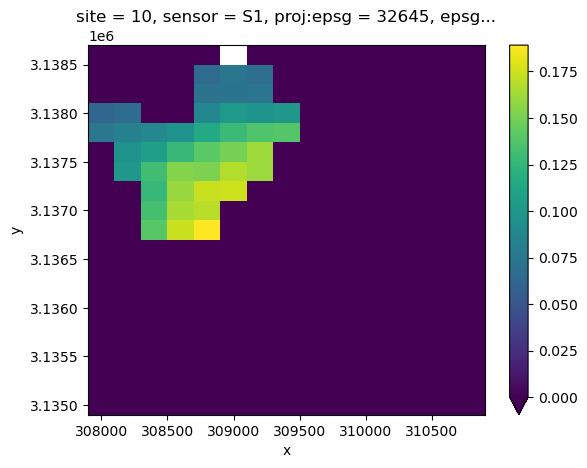

In [307]:
z0_vv.mean(dim='time').plot(vmin=0)

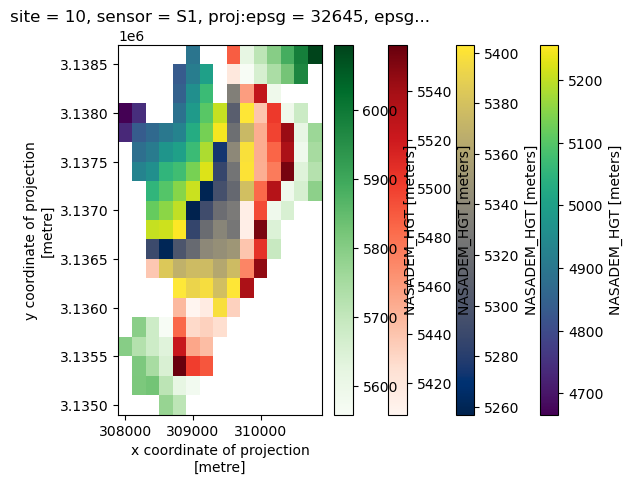

In [271]:
fig, ax = plt.subplots()
retreat_03976_ds.z0.plot(ax=ax)
retreat_03976_ds.z1.plot(ax=ax, cmap='cividis')
retreat_03976_ds.z2.plot(ax=ax, cmap='Reds')
retreat_03976_ds.z3.plot(ax=ax, cmap='Greens')

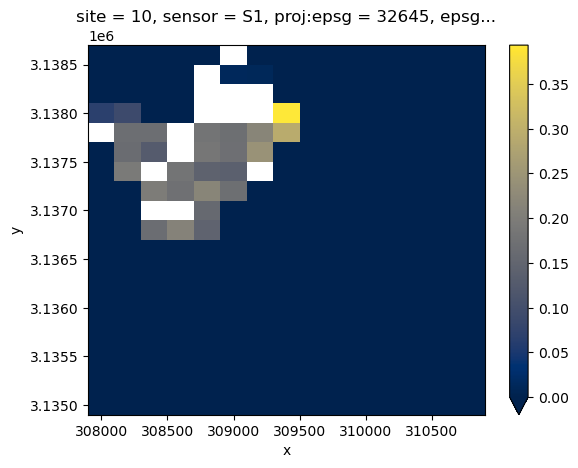

In [298]:
fig, ax = plt.subplots()
xr.where(retreat_03976_ds.z0.notnull(), retreat_03976_ds.dis_mag, -999.).isel(time=4).plot(ax=ax, vmin=0, cmap='cividis')
#xr.where(retreat_03976_ds.z1.notnull(), retreat_03976_ds.dis_mag, -999.).isel(time=1).plot(ax=ax, vmin=0)
#xr.where(retreat_03976_ds.z2.notnull(), retreat_03976_ds.dis_mag, -999.).isel(time=1).plot(ax=ax, vmin=0, cmap='cividis')
#xr.where(retreat_03976_ds.z3.notnull(), retreat_03976_ds.dis_mag, -999.).isel(time=1).plot(ax=ax, vmin=0, cmap='cividis')



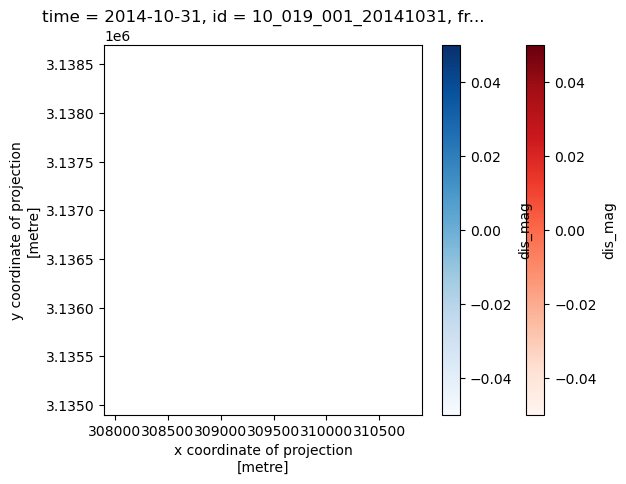

In [281]:
fig, ax = plt.subplots()
retreat_03976_ds.isel(time=1).where(retreat_03976_ds.z1 < 0).dis_mag.plot(ax=ax, cmap='Reds')
retreat_03976_ds.isel(time=1).where(retreat_03976_ds.z2 < 0).dis_mag.plot(ax=ax, cmap='Blues')

In [261]:
retreat_03976_ds.z0.plot(ax=ax)


In [239]:
z1 = dem_03976_downsamp.NASADEM_HGT.where(np.logical_and(dem_03976_downsamp.NASADEM_HGT >= 5256.25, dem_03976_downsamp.NASADEM_HGT <= 5405.), drop=True)


In [72]:
retreat_03976['z'] = (('y','x'), dem_03976_downsamp.NASADEM_HGT.data)

In [215]:
retreat_03976_ds

<xarray.Dataset>
Dimensions:      (time: 314, y: 19, x: 15, band: 5)
Coordinates: (12/18)
  * time         (time) datetime64[ns] 2014-10-23 2014-10-31 ... 2021-11-05
    id           (time) <U19 '10_085_002_20141023' ... '10_019_085_20211105'
  * x            (x) float64 3.08e+05 3.082e+05 ... 3.106e+05 3.108e+05
  * y            (y) float64 3.139e+06 3.138e+06 ... 3.135e+06 3.135e+06
    frame        (time) <U3 '085' '019' '019' '085' ... '019' '019' '019' '019'
    orbit        (time) <U3 '002' '001' '010' '002' ... '085' '085' '085' '085'
    ...           ...
    sec_date     (time) <U15 'S1_20141104T122' ... '20211111T001930'
    title        (band) <U9 'dis_ang' 'dis_az' 'dis_mag' 'dis_N_ang' 'dis_r'
    proj:epsg    int64 32645
    epsg         int64 32645
    spatial_ref  int64 0
    z            (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Dimensions without coordinates: band
Data variables:
    dis_ang      (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    dis_az       (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    dis_mag      (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    dis_N_ang    (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    dis_r        (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
Attributes:
    spec:        RasterSpec(epsg=32645, bounds=(112800.0, 2966800.0, 487800.0...
    resolution:  200.0

In [221]:
np.nanpercentile(retreat_03976_ds.z.data, 50)

5405.0

In [220]:
retreat_03976_ds.where(np.logical_and(retreat_03976_ds.z <= 5405., retreat_03976.z >= 5256.25),  drop=True).z.max()

<xarray.DataArray 'z' ()>
array(5536., dtype=float32)
Coordinates:
    site         <U2 '10'
    sensor       <U2 'S1'
    proj:epsg    int64 32645
    epsg         int64 32645
    spatial_ref  int64 0

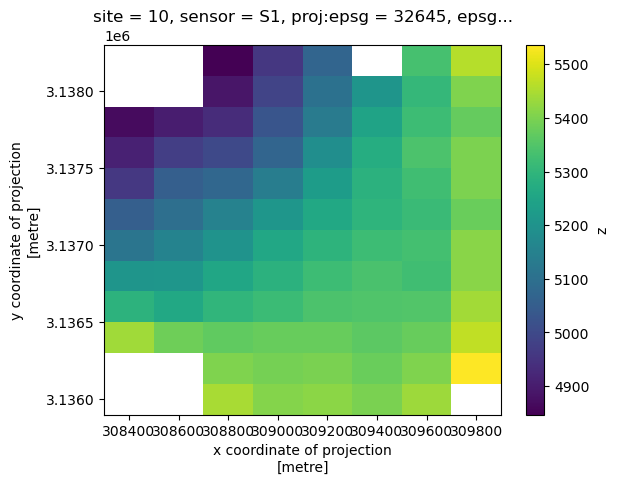

In [223]:
retreat_03976_ds.where(np.logical_and(retreat_03976_ds.z <= 5405., retreat_03976.z >= 5256.25),  drop=True).z.plot()

In [207]:
z0_condition = retreat_03976_ds.z <= 5256.25

In [208]:
z0_subset = retreat_03976_ds.sel(z = z0_condition)

KeyError: "no index found for coordinate 'z'"

In [192]:
zmin = np.nanmin(retreat_03976['z'].data)
zq1 = np.nanpercentile(retreat_03976['z'].data, 25)
zmed = np.nanmedian(retreat_03976['z'].data)
zq3 = np.nanpercentile(retreat_03976['z'].data, 75)
zmax = np.nanmax(retreat_03976['z'].data)

print(zmin)
print(zq1)
print(zmed)
print(zq3)
print(zmax)
    
#define z groups
z_group0 = retreat_03976_ds.where(np.logical_and(retreat_03976_ds.z >= zmin, retreat_03976_ds.z < 5337), drop=True)
#z_group1 = retreat_03976_ds.where(np.logical_and(retreat_03976_ds.z > 5256.25, retreat_03976_ds.z <= 5405.), drop=True)
#z_group2 = retreat_03976_ds.where(np.logical_and(retreat_03976_ds.z > 5405, retreat_03976_ds.z <= 5559.), drop=True)
#z_group3 = retreat_03976_ds.where(np.logical_and(retreat_03976_ds.z > 5559., retreat_03976_ds.z <= zmax), drop=True)

4666.0
5256.25
5405.0
5559.0
6094.0


In [193]:
z_group0.z.max()

<xarray.DataArray 'z' ()>
array(5488., dtype=float32)
Coordinates:
    site         <U2 '10'
    sensor       <U2 'S1'
    proj:epsg    int64 32645
    epsg         int64 32645
    spatial_ref  int64 0

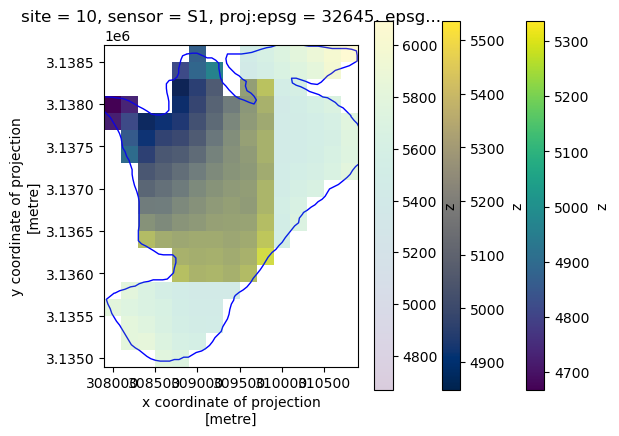

In [187]:
fig, ax = plt.subplots()

z_group0.z.plot(ax=ax)

z_group1.z.plot(ax=ax, cmap='cividis')

rgi_03976.plot(ax=ax, facecolor='None', edgecolor='Blue')
retreat_03976_ds.z.plot(ax=ax, alpha = 0.2)

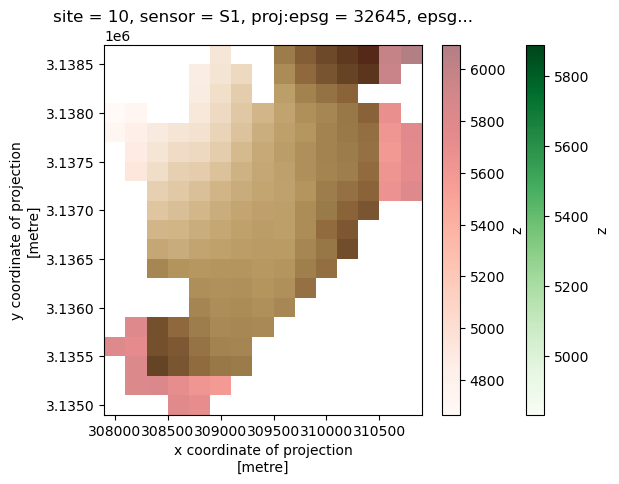

In [161]:
fig, ax = plt.subplots() 

retreat_03976_ds.where(np.logical_and(retreat_03976_ds.z >= 5405, retreat_03976_ds.z <= 5559), drop=True).z.plot(ax=ax, cmap='Greens')
#retreat_03976_ds.where(np.logical_and(retreat_03976_ds.z >= 5256.25, retreat_03976_ds.z <= 5405), drop=True).z.plot(ax=ax, cmap='cividis')
#retreat_03976_ds.where(np.logical_and(retreat_03976_ds.z >= 4666., retreat_03976_ds.z <= 5256.25), drop=True).z.plot(ax=ax)

retreat_03976_ds.z.plot( alpha = 0.5, ax=ax, cmap='Reds')


In [78]:
import numpy as np
np.nanmedian(retreat_03976.z)

5405.0

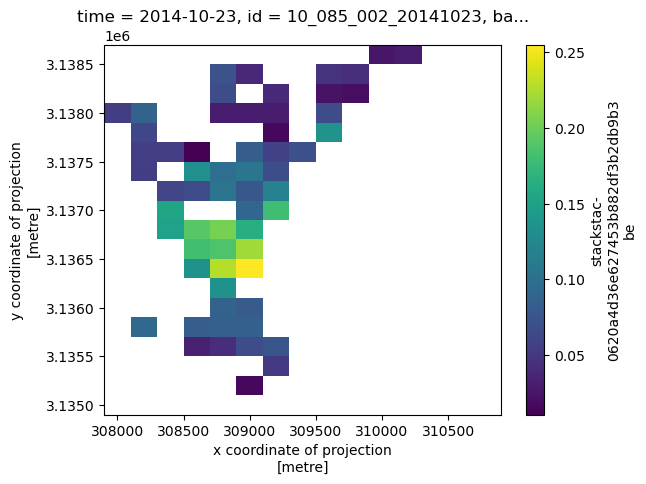

In [52]:
retreat_03976.isel(time=0).sel(band='dis_mag').plot()